# 多层神经网络，Sequential 和 Module
通过前面的章节，我们了解到了机器学习领域中最常见的两个模型，线性回归模型和 Logistic 回归模型，他们分别是处理机器学习中最常见的两类问题-回归问题和分类问题。

下面我们会讲第一个深度学习的模型，多层神经网络。

In [1]:
import torch
import numpy as np
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def plot_decision_boundary(model, x, y):
    # Set min and max values and give it some padding
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(x[:, 0], x[:, 1], c=y.reshape(-1), s=40, cmap=plt.cm.Spectral)

这次我们仍然处理一个二分类问题，但是比前面的 logistic 回归更加复杂

In [3]:
np.random.seed(1)
m = 400 # 样本数量
N = int(m/2) # 每一类的点的个数
D = 2 # 维度
x = np.zeros((m, D))
y = np.zeros((m, 1), dtype='uint8') # label 向量，0 表示红色，1 表示蓝色
a = 4

for j in range(2):
    ix = range(N*j,N*(j+1))
    t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
    r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
    x[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j

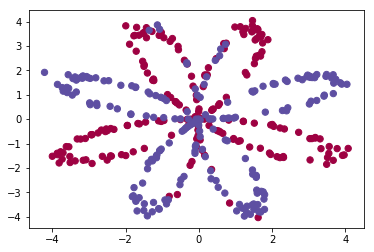

In [4]:
plt.scatter(x[:, 0], x[:, 1], c=y.reshape(-1), s=40, cmap=plt.cm.Spectral)

我们可以先尝试用 logistic 回归来解决这个问题

In [5]:
x = torch.from_numpy(x).float()
y = torch.from_numpy(y).float()

In [6]:
w = nn.Parameter(torch.randn(2, 1))
b = nn.Parameter(torch.zeros(1))

optimizer = torch.optim.SGD([w, b], 1e-1)

def logistic_regression(x):
    return torch.mm(x, w) + b

criterion = nn.BCEWithLogitsLoss()

In [7]:
for e in range(100):
    out = logistic_regression(Variable(x))
    loss = criterion(out, Variable(y))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 20 == 0:
        print('epoch: {}, loss: {}'.format(e+1, loss.data[0]))

epoch: 20, loss: 0.7033562064170837
epoch: 40, loss: 0.6739853024482727
epoch: 60, loss: 0.6731640696525574
epoch: 80, loss: 0.6731465458869934
epoch: 100, loss: 0.6731461882591248


In [8]:
def plot_logistic(x):
    x = Variable(torch.from_numpy(x).float())
    out = F.sigmoid(logistic_regression(x))
    out = (out > 0.5) * 1
    return out.data.numpy()

Text(0.5,1,'logistic regression')

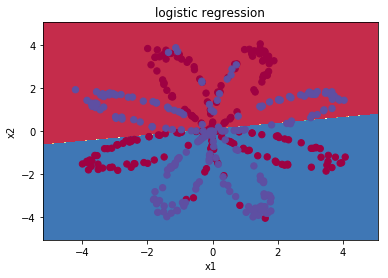

In [9]:
plot_decision_boundary(lambda x: plot_logistic(x), x.numpy(), y.numpy())
plt.title('logistic regression')

可以看到，logistic 回归并不能很好的区分开这个复杂的数据集，如果你还记得前面的内容，你就知道 logistic 回归是一个线性分类器，这个时候就该我们的神经网络登场了！

In [10]:
# 定义两层神经网络的参数
w1 = nn.Parameter(torch.randn(2, 4) * 0.01) # 隐藏层神经元个数 2
b1 = nn.Parameter(torch.zeros(4))

w2 = nn.Parameter(torch.randn(4, 1) * 0.01)
b2 = nn.Parameter(torch.zeros(1))

# 定义模型
def two_network(x):
    x1 = torch.mm(x, w1) + b1
    x1 = F.tanh(x1) # 使用 PyTorch 自带的 tanh 激活函数
    x2 = torch.mm(x1, w2) + b2
    return x2

optimizer = torch.optim.SGD([w1, w2, b1, b2], 1.)

criterion = nn.BCEWithLogitsLoss()

In [11]:
# 我们训练 10000 次
for e in range(10000):
    out = two_network(Variable(x))
    loss = criterion(out, Variable(y))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 1000 == 0:
        print('epoch: {}, loss: {}'.format(e+1, loss.data[0]))

epoch: 1000, loss: 0.29002276062965393
epoch: 2000, loss: 0.276983380317688
epoch: 3000, loss: 0.26818233728408813
epoch: 4000, loss: 0.2620616555213928
epoch: 5000, loss: 0.2571246325969696
epoch: 6000, loss: 0.23155273497104645
epoch: 7000, loss: 0.2241673469543457
epoch: 8000, loss: 0.220903217792511
epoch: 9000, loss: 0.21872615814208984
epoch: 10000, loss: 0.2170446664094925


In [12]:
def plot_network(x):
    x = Variable(torch.from_numpy(x).float())
    x1 = torch.mm(x, w1) + b1
    x1 = F.tanh(x1)
    x2 = torch.mm(x1, w2) + b2
    out = F.sigmoid(x2)
    out = (out > 0.5) * 1
    return out.data.numpy()

Text(0.5,1,'2 layer network')

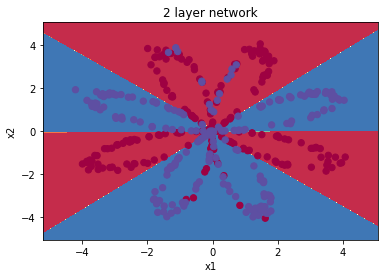

In [13]:
plot_decision_boundary(lambda x: plot_network(x), x.numpy(), y.numpy())
plt.title('2 layer network')

可以看到神经网络能够非常好地分类这个复杂的数据，和前面的 logistic 回归相比，神经网络因为有了激活函数的存在，成了一个非线性分类器，所以神经网络分类的边界更加复杂。

## Sequential 和 Module
我们讲了数据处理，模型构建，loss 函数设计等等内容，但是目前为止我们还没有准备好构建一个完整的机器学习系统，一个完整的机器学习系统需要我们不断地读写模型。在现实应用中，一般我们会将模型在本地进行训练，然后保存模型，接着我们会将模型部署到不同的地方进行应用，所以在这节课我们会教大家如何保存 PyTorch 的模型。

首先我们会讲一下 PyTorch 中的模块，Sequential 和 Module。

对于前面的线性回归模型、 Logistic回归模型和神经网络，我们在构建的时候定义了需要的参数。这对于比较小的模型是可行的，但是对于大的模型，比如100 层的神经网络，这个时候再去手动定义参数就显得非常麻烦，所以 PyTorch 提供了两个模块来帮助我们构建模型，一个是Sequential，一个是 Module。

我们下面分别用 Sequential 和 Module 来定义上面的神经网络。

In [14]:
# Sequential
seq_net = nn.Sequential(
    nn.Linear(2, 4), # PyTorch 中的线性层，wx + b
    nn.Tanh(),
    nn.Linear(4, 1)
)

In [15]:
# 序列模块可以通过索引访问每一层

seq_net[0] # 第一层

Linear(in_features=2, out_features=4)

In [16]:
# 打印出第一层的权重

w0 = seq_net[0].weight
print(w0)

Parameter containing:
-0.4964  0.3581
-0.0705  0.4262
 0.0601  0.1988
 0.6683 -0.4470
[torch.FloatTensor of size 4x2]



In [17]:
# 通过 parameters 可以取得模型的参数
param = seq_net.parameters()

# 定义优化器
optim = torch.optim.SGD(param, 1.)

In [18]:
# 我们训练 10000 次
for e in range(10000):
    out = seq_net(Variable(x))
    loss = criterion(out, Variable(y))
    optim.zero_grad()
    loss.backward()
    optim.step()
    if (e + 1) % 1000 == 0:
        print('epoch: {}, loss: {}'.format(e+1, loss.data[0]))

epoch: 1000, loss: 0.2839296758174896
epoch: 2000, loss: 0.2716798782348633
epoch: 3000, loss: 0.2647360861301422
epoch: 4000, loss: 0.26001378893852234
epoch: 5000, loss: 0.2566395103931427
epoch: 6000, loss: 0.2541380524635315
epoch: 7000, loss: 0.25222381949424744
epoch: 8000, loss: 0.2507193386554718
epoch: 9000, loss: 0.24951006472110748
epoch: 10000, loss: 0.2485194206237793


可以看到，训练 10000 次 loss 比之前的更低，这是因为 PyTorch 自带的模块比我们写的更加稳定，同时也有一些初始化的问题在里面，关于参数初始化，我们会在后面的课程中讲到

In [19]:
def plot_seq(x):
    out = F.sigmoid(seq_net(Variable(torch.from_numpy(x).float()))).data.numpy()
    out = (out > 0.5) * 1
    return out

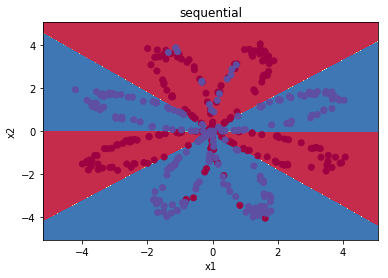

In [20]:
plot_decision_boundary(lambda x: plot_seq(x), x.numpy(), y.numpy())
plt.title('sequential')

最后我们讲一讲如何保存模型，保存模型在 PyTorch 中有两种方式，一种是将模型结构和参数都保存在一起，一种是只将参数保存下来，下面我们一一介绍。

In [21]:
# 将参数和模型保存在一起
torch.save(seq_net, 'save_seq_net.pth')

上面就是保存模型的方式，`torch.save`里面有两个参数，第一个是要保存的模型，第二个参数是保存的路径，读取模型的方式也非常简单

In [22]:
# 读取保存的模型
seq_net1 = torch.load('save_seq_net.pth')

In [23]:
seq_net1

Sequential(
  (0): Linear(in_features=2, out_features=4)
  (1): Tanh()
  (2): Linear(in_features=4, out_features=1)
)

In [28]:
print(seq_net1[0].weight)

Parameter containing:
 -0.5532  -1.9916
  0.0446   7.9446
 10.3188 -12.9290
 10.0688  11.7754
[torch.FloatTensor of size 4x2]



我们可以看到我们重新读入了模型，并且将其命名为 seq_net1，并且打印了第一层的参数

下面我们看看第二种保存模型的方式，只保存参数而不保存模型结构

In [24]:
# 保存模型参数
torch.save(seq_net.state_dict(), 'save_seq_net_params.pth')

通过上面的方式，我们保存了模型的参数，如果要重新读入模型的参数，首先我们需要重新定义一次模型，接着重新读入参数

In [26]:
seq_net2 = nn.Sequential(
    nn.Linear(2, 4),
    nn.Tanh(),
    nn.Linear(4, 1)
)

seq_net2.load_state_dict(torch.load('save_seq_net_params.pth'))

In [27]:
seq_net2

Sequential(
  (0): Linear(in_features=2, out_features=4)
  (1): Tanh()
  (2): Linear(in_features=4, out_features=1)
)

In [29]:
print(seq_net2[0].weight)

Parameter containing:
 -0.5532  -1.9916
  0.0446   7.9446
 10.3188 -12.9290
 10.0688  11.7754
[torch.FloatTensor of size 4x2]



通过这种方式我们也重新读入了相同的模型，打印第一层的参数对比，发现和前面的办法是一样

有这两种保存和读取模型的方法，我们推荐使用**第二种**，因为第二种可移植性更强

下面我们再用 Module 定义这个模型，下面是使用 Module 的模板

```
class 网络名字(nn.Module):
    def __init__(self, 一些定义的参数):
        super(网络名字, self).__init__()
        self.layer1 = nn.Linear(num_input, num_hidden)
        self.layer2 = nn.Sequential(...)
        ...
        
        定义需要用的网络层
        
    def forward(self, x): # 定义前向传播
        x1 = self.layer1(x)
        x2 = self.layer2(x)
        x = x1 + x2
        ...
        return x
```

注意的是，Module 里面也可以使用 Sequential，同时 Module 非常灵活，具体体现在 forward 中，如何复杂的操作都能直观的在 forward 里面执行

下面我们照着模板实现一下上面的神经网络

In [30]:
class module_net(nn.Module):
    def __init__(self, num_input, num_hidden, num_output):
        super(module_net, self).__init__()
        self.layer1 = nn.Linear(num_input, num_hidden)
        
        self.layer2 = nn.Tanh()
        
        self.layer3 = nn.Linear(num_hidden, num_output)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

In [31]:
mo_net = module_net(2, 4, 1)

In [32]:
# 访问模型中的某层可以直接通过名字

# 第一层
l1 = mo_net.layer1
print(l1)

Linear(in_features=2, out_features=4)


In [33]:
# 打印出第一层的权重
print(l1.weight)

Parameter containing:
 0.1492  0.4150
 0.3403 -0.4084
-0.3114 -0.0584
 0.5668  0.2063
[torch.FloatTensor of size 4x2]



In [34]:
# 定义优化器
optim = torch.optim.SGD(mo_net.parameters(), 1.)

In [35]:
# 我们训练 10000 次
for e in range(10000):
    out = mo_net(Variable(x))
    loss = criterion(out, Variable(y))
    optim.zero_grad()
    loss.backward()
    optim.step()
    if (e + 1) % 1000 == 0:
        print('epoch: {}, loss: {}'.format(e+1, loss.data[0]))

epoch: 1000, loss: 0.2618132531642914
epoch: 2000, loss: 0.2421271800994873
epoch: 3000, loss: 0.23346386849880219
epoch: 4000, loss: 0.22809192538261414
epoch: 5000, loss: 0.224302738904953
epoch: 6000, loss: 0.2214415818452835
epoch: 7000, loss: 0.21918588876724243
epoch: 8000, loss: 0.21736061573028564
epoch: 9000, loss: 0.21585838496685028
epoch: 10000, loss: 0.21460506319999695


In [36]:
# 保存模型
torch.save(mo_net.state_dict(), 'module_net.pth')

可以看到我们得到了相同的结果，而且使用 Sequential 和 Module 来定义模型更加方便

在这一节中我们还是使用梯度下降法来优化参数，在神经网络中，这种优化方法有一个特别的名字，反向传播算法，下一次课我们会讲一讲什么是反向传播算法

**小练习：改变网络的隐藏层神经元数目，或者试试定义一个 5 层甚至更深的模型，增加训练次数，改变学习率，看看结果会怎么样**

下面举个例子

In [103]:
net = nn.Sequential(
    nn.Linear(2, 10),
    nn.Tanh(),
    nn.Linear(10, 10),
    nn.Tanh(),
    nn.Linear(10, 10),
    nn.Tanh(),
    nn.Linear(10, 1)
)

optim = torch.optim.SGD(net.parameters(), 0.1)

In [104]:
# 我们训练 20000 次
for e in range(20000):
    out = net(Variable(x))
    loss = criterion(out, Variable(y))
    optim.zero_grad()
    loss.backward()
    optim.step()
    if (e + 1) % 1000 == 0:
        print('epoch: {}, loss: {}'.format(e+1, loss.data[0]))

epoch: 1000, loss: 0.3165791928768158
epoch: 2000, loss: 0.25367119908332825
epoch: 3000, loss: 0.22129501402378082
epoch: 4000, loss: 0.20364265143871307
epoch: 5000, loss: 0.19186729192733765
epoch: 6000, loss: 0.18199527263641357
epoch: 7000, loss: 0.173702672123909
epoch: 8000, loss: 0.16727975010871887
epoch: 9000, loss: 0.16238373517990112
epoch: 10000, loss: 0.15855807065963745
epoch: 11000, loss: 0.15542374551296234
epoch: 12000, loss: 0.1527201235294342
epoch: 13000, loss: 0.15030623972415924
epoch: 14000, loss: 0.14812862873077393
epoch: 15000, loss: 0.1461697667837143
epoch: 16000, loss: 0.14440736174583435
epoch: 17000, loss: 0.14280635118484497
epoch: 18000, loss: 0.1413293182849884
epoch: 19000, loss: 0.13908402621746063
epoch: 20000, loss: 0.13768813014030457


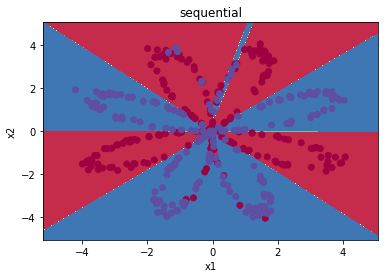

In [105]:
def plot_net(x):
    out = F.sigmoid(net(Variable(torch.from_numpy(x).float()))).data.numpy()
    out = (out > 0.5) * 1
    return out

plot_decision_boundary(lambda x: plot_net(x), x.numpy(), y.numpy())
plt.title('sequential')